In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/ML Project/data_reduced.zip'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import shutil
import os 

# define function to plot results

def plot_history(history, yrange):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    # Plot training and validation accuracy per epoch
    plt.subplot(1,2,1)
    plt.plot(epochs, acc,  label='Train')
    plt.plot(epochs, val_acc , label='Val')
    
    plt.title('Classification Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.ylim(yrange)
    plt.legend(['Train', 'Val'], loc='lower right')
    
    # Plot training and validation loss per epoch
    #plt.figure()
    plt.subplot(1,2,2)
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    
    plt.title('Classification Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    
    #plt.show()
    plt.tight_layout()

In [4]:
from tensorflow.keras.applications import MobileNet

img_rows, img_cols = 224, 224 

mobilenet = MobileNet(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

17235968/17225924 [==============================] - 0s 0us/step


In [5]:
# print layers 
for (i,layer) in enumerate(mobilenet.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer True
1 Conv2D True
2 BatchNormalization True
3 ReLU True
4 DepthwiseConv2D True
5 BatchNormalization True
6 ReLU True
7 Conv2D True
8 BatchNormalization True
9 ReLU True
10 ZeroPadding2D True
11 DepthwiseConv2D True
12 BatchNormalization True
13 ReLU True
14 Conv2D True
15 BatchNormalization True
16 ReLU True
17 DepthwiseConv2D True
18 BatchNormalization True
19 ReLU True
20 Conv2D True
21 BatchNormalization True
22 ReLU True
23 ZeroPadding2D True
24 DepthwiseConv2D True
25 BatchNormalization True
26 ReLU True
27 Conv2D True
28 BatchNormalization True
29 ReLU True
30 DepthwiseConv2D True
31 BatchNormalization True
32 ReLU True
33 Conv2D True
34 BatchNormalization True
35 ReLU True
36 ZeroPadding2D True
37 DepthwiseConv2D True
38 BatchNormalization True
39 ReLU True
40 Conv2D True
41 BatchNormalization True
42 ReLU True
43 DepthwiseConv2D True
44 BatchNormalization True
45 ReLU True
46 Conv2D True
47 BatchNormalization True
48 ReLU True
49 DepthwiseConv2D True
50 BatchNorma

In [15]:
def Fc(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    #top_model = Flatten()(top_model)

    #top_model = Dense(256,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)

    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model

# Set the class number to 1000 for the dataset
num_classes = 200

FC_Head = Fc(mobilenet, num_classes)

model = Model(inputs = mobilenet.input, outputs = FC_Head)

print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [8]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = '/content/data_reduced/train_data/'
validation_data_dir = '/content/data_reduced/val_data/'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True
        )
 
validation_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
 
batch_size = 16
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 16095 images belonging to 200 classes.
Found 400 images belonging to 200 classes.


In [17]:
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Nadam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import math

checkpoint = ModelCheckpoint("/content/drive/MyDrive/ML Project/best_weights/mobilenet_weights.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
#callbacks = [lrate, earlystop, checkpoint]
callbacks = [earlystop, checkpoint]
# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(learning_rate = 0.001),
              metrics = ['accuracy', 'AUC'])

In [18]:
# Enter the number of training and validation samples here
nb_train_samples = 16095
nb_validation_samples = 400
# We only train 5 EPOCHS 
initial_epochs = 7

batch_size = 16

history = model.fit(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = initial_epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size
    )

Epoch 1/7
1005/1005 [==============================] - ETA: 0s - loss: 4.2549 - accuracy: 0.0815 - auc: 0.8148
Epoch 00001: val_loss improved from inf to 5.09464, saving model to /content/drive/MyDrive/ML Project/best_weights/mobilenet_weights.h5
1005/1005 [==============================] - 2814s 3s/step - loss: 4.2549 - accuracy: 0.0815 - auc: 0.8148 - val_loss: 5.0946 - val_accuracy: 0.0600 - val_auc: 0.7587
Epoch 2/7
1005/1005 [==============================] - ETA: 0s - loss: 3.2314 - accuracy: 0.2173 - auc: 0.9135
Epoch 00002: val_loss improved from 5.09464 to 4.40835, saving model to /content/drive/MyDrive/ML Project/best_weights/mobilenet_weights.h5
1005/1005 [==============================] - 2748s 3s/step - loss: 3.2314 - accuracy: 0.2173 - auc: 0.9135 - val_loss: 4.4083 - val_accuracy: 0.1500 - val_auc: 0.8249
Epoch 3/7
1005/1005 [==============================] - ETA: 0s - loss: 2.7412 - accuracy: 0.3143 - auc: 0.9364
Epoch 00003: val_loss improved from 4.40835 to 3.34642, s

In [19]:
model.save_weights('/content/drive/MyDrive/ML Project/best_weights/mobilenet_weights.h5')

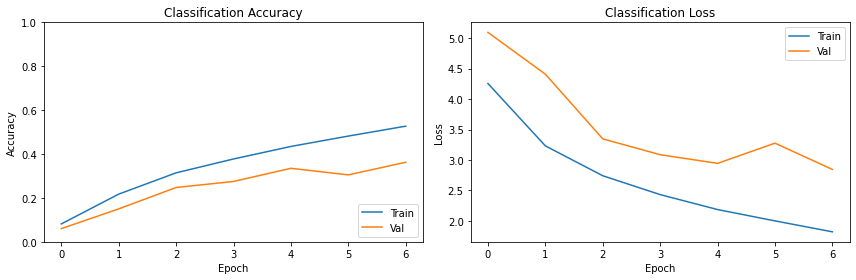

In [20]:
# plot the model's result

mobilenet_train_acc_cat = history.history['accuracy']
mobilenet_val_acc_cat = history.history['val_accuracy']

plot_history(history, yrange=(0,1))

In [ ]:
# load saved model for prediction
#from keras.models import load_model

# load model
#model = load_model('/content/drive/MyDrive/ML Project/best_weights/mobilenet_checkpoint.h5')

In [21]:
target = [
        'n000003',
        'n000010',
        'n000011',
        'n000013',
        'n000015',
        'n000017',
        'n000018',
        'n000020',
        'n000023',
        'n000024',
        'n000025',
        'n000028',
        'n000032',
        'n000033',
        'n000034',
        'n000035',
        'n000038',
        'n000041',
        'n000042',
        'n000046',
        'n000048',
        'n000049',
        'n000051',
        'n000053',
        'n000054',
        'n000057',
        'n000059',
        'n000062',
        'n000064',
        'n000065',
        'n000070',
        'n000072',
        'n000074',
        'n000075',
        'n000077',
        'n000086',
        'n000088',
        'n000089',
        'n000093',
        'n000101',
        'n000108',
        'n000110',
        'n000111',
        'n000113',
        'n000115',
        'n000118',
        'n000119',
        'n000120',
        'n000121',
        'n000125',
        'n000127',
        'n000130',
        'n000131',
        'n000143',
        'n000150',
        'n000151',
        'n000154',
        'n000155',
        'n000157',
        'n000158',
        'n000159',
        'n000163',
        'n000167',
        'n000168',
        'n000170',
        'n000171',
        'n000182',
        'n000185',
        'n000187',
        'n000188',
        'n000189',
        'n000192',
        'n000193',
        'n000195',
        'n000196',
        'n000197',
        'n000199',
        'n000202',
        'n000203',
        'n000204',
        'n000207',
        'n000208',
        'n000210',
        'n000211',
        'n000212',
        'n000214',
        'n000216',
        'n000217',
        'n000218',
        'n000219',
        'n000221',
        'n000224',
        'n000229',
        'n000231',
        'n000234',
        'n000236',
        'n000239',
        'n000240',
        'n000243',
        'n000248',
        'n000249',
        'n000250',
        'n000252',
        'n000253',
        'n000254',
        'n000256',
        'n000258',
        'n000261',
        'n000265',
        'n000267',
        'n000274',
        'n000276',
        'n000279',
        'n000281',
        'n000283',
        'n000285',
        'n000286',
        'n000287',
        'n000289',
        'n000290',
        'n000291',
        'n000295',
        'n000297',
        'n000298',
        'n000300',
        'n000303',
        'n000304',
        'n000306',
        'n000308',
        'n000309',
        'n000310',
        'n000311',
        'n000318',
        'n000323',
        'n000324',
        'n000327',
        'n000329',
        'n000332',
        'n000333',
        'n000334',
        'n000335',
        'n000336',
        'n000339',
        'n000340',
        'n000345',
        'n000347',
        'n000349',
        'n000351',
        'n000352',
        'n000354',
        'n000355',
        'n000357',
        'n000358',
        'n000359',
        'n000360',
        'n000361',
        'n000364',
        'n000365',
        'n000367',
        'n000369',
        'n000371',
        'n000375',
        'n000376',
        'n000379',
        'n000380',
        'n000383',
        'n000386',
        'n000387',
        'n000390',
        'n000391',
        'n000392',
        'n000397',
        'n000402',
        'n000403',
        'n000413',
        'n000415',
        'n000417',
        'n000418',
        'n000419',
        'n000420',
        'n000422',
        'n000423',
        'n000424',
        'n000427',
        'n000429',
        'n000434',
        'n000435',
        'n000437',
        'n000441',
        'n000442',
        'n000443',
        'n000444',
        'n000446',
        'n000449',
        'n000450',
        'n000451',
        'n000455',
        'n000457',
        'n000458',
        'n000461']

25/25 [==============================] - 13s 517ms/step
ROC AUC score:  0.6809045226130652


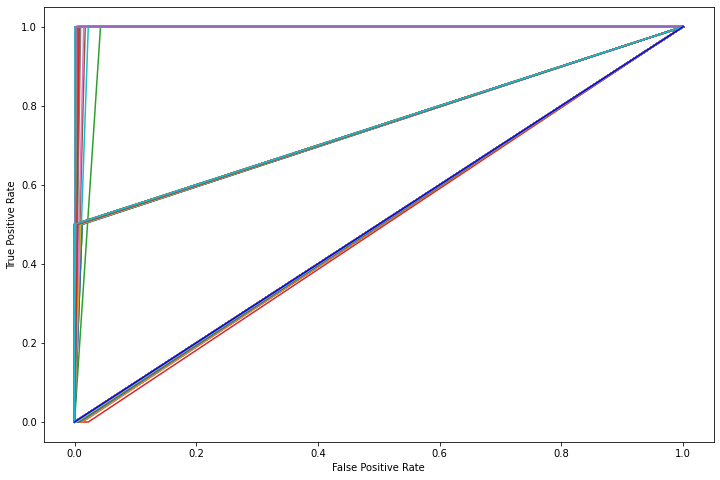

In [22]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt 
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target): # all_labels: no. of the labels
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

# calling
validation_generator.reset() # resetting generator
y_pred = model.predict(validation_generator, verbose = True)
y_pred = np.argmax(y_pred, axis=1)


c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
print('ROC AUC score: ', multiclass_roc_auc_score(validation_generator.classes, y_pred))

# Finetune and retrain model

In [23]:
def Fc(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    #top_model = Flatten()(top_model)

    #top_model = Dense(256,activation='relu')(top_model)
    top_model = Dense(256,activation='relu')(top_model)
    top_model = Dense(256,activation='relu')(top_model)

    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [24]:
FC_Head = Fc(mobilenet, num_classes)

model = Model(inputs = mobilenet.input, outputs = FC_Head)

print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [25]:
mobilenet.trainable = True

# show how many layers are in the base model
print("Number of layers in the base model: ", len(mobilenet.layers))

Number of layers in the base model:  86


In [26]:
# Fine-tune from this layer onwards
fine_tune_at = 70

# Freeze all the layers before the `fine_tune_at` layer
for layer in mobilenet.layers[:fine_tune_at]:
  layer.trainable =  False

In [27]:
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Nadam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("/content/drive/MyDrive/ML Project/best_weights/mobilenet_weights.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
#callbacks = [lrate, earlystop, checkpoint]
callbacks = [earlystop, checkpoint]
# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(learning_rate = 0.001),
              metrics = ['accuracy', 'AUC'])

In [28]:
# retrain for 5 more epochs
finetune_epochs = 10

total_epochs = initial_epochs + finetune_epochs

history_tuned = model.fit( 
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = total_epochs,
    initial_epoch =  history.epoch[-1],
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size
    )

Epoch 7/17
1005/1005 [==============================] - ETA: 0s - loss: 2.2959 - accuracy: 0.4417 - auc: 0.9414
Epoch 00007: val_loss improved from inf to 2.54973, saving model to /content/drive/MyDrive/ML Project/best_weights/mobilenet_weights.h5
1005/1005 [==============================] - 859s 853ms/step - loss: 2.2959 - accuracy: 0.4417 - auc: 0.9414 - val_loss: 2.5497 - val_accuracy: 0.3900 - val_auc: 0.9234
Epoch 8/17
1005/1005 [==============================] - ETA: 0s - loss: 1.4398 - accuracy: 0.6089 - auc: 0.9741
Epoch 00008: val_loss improved from 2.54973 to 2.42350, saving model to /content/drive/MyDrive/ML Project/best_weights/mobilenet_weights.h5
1005/1005 [==============================] - 850s 846ms/step - loss: 1.4398 - accuracy: 0.6089 - auc: 0.9741 - val_loss: 2.4235 - val_accuracy: 0.4500 - val_auc: 0.9295
Epoch 9/17
1005/1005 [==============================] - ETA: 0s - loss: 1.2522 - accuracy: 0.6554 - auc: 0.9788
Epoch 00009: val_loss did not improve from 2.42350

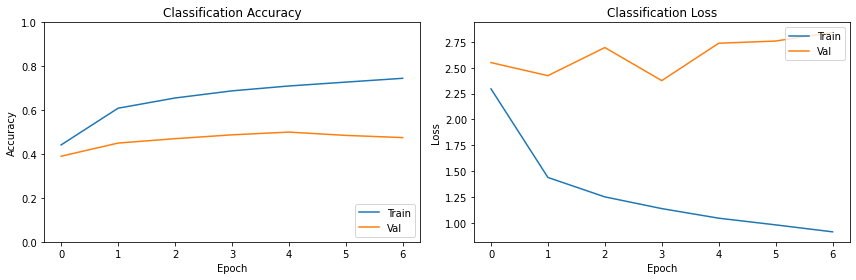

In [29]:
# plot the model's result

mobilenet_tuned_train_acc_cat = history_tuned.history['accuracy']
mobilenet_tuned_val_acc_cat = history_tuned.history['val_accuracy']

plot_history(history_tuned, yrange=(0,1))

25/25 [==============================] - 13s 515ms/step
ROC AUC score:  0.7349246231155778


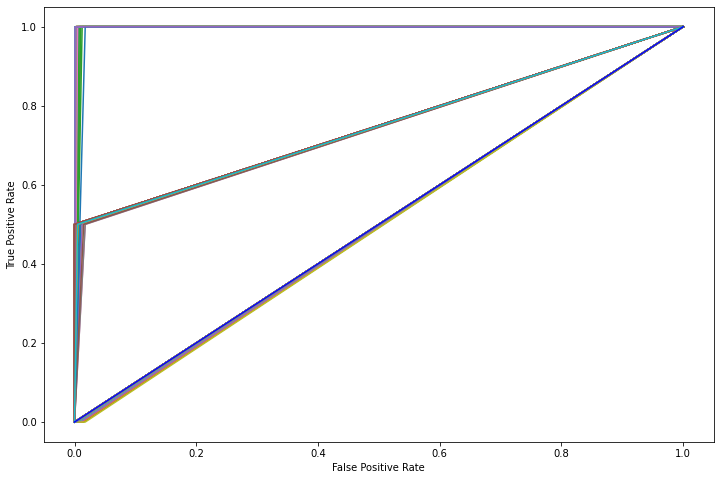

In [30]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt 
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# calling
validation_generator.reset() # resetting generator
y_pred = model.predict(validation_generator, verbose = True)
y_pred = np.argmax(y_pred, axis=1)


c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
print('ROC AUC score: ', multiclass_roc_auc_score(validation_generator.classes, y_pred))

# Test the model

In [31]:
# define function for testing the models

from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
import random

def model_tester(full_model):
    
    %matplotlib inline

    # This first part selects a random file from the validation directory
    type = random.choice(os.listdir('/content/data_reduced/test_data'))
    #print(type)
    file = random.choice(os.listdir(f'/content/data_reduced/test_data/{type}'))
    #print(file)

    random_path = '/content/data_reduced/test_data' + '/' + type + '/' + file
    #print(random_path)

    # We then create the list of labels 
    person_dict = train_generator.class_indices
    label_list = {v: k.lower().capitalize() for k, v in person_dict.items()}
    label_list

    # We then select the image, preprocess and predict the values from full_model
    img_path = random_path
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    answer=full_model.predict(x)
    probability=round(np.max(full_model.predict(x)*100),2)
    
    # Prediction
    print ('This model suggests the image below is a: ',
           label_list[np.argmax(full_model.predict(x)*100)],
           ' with a probability of' ,probability,'%' ) 
    
    plt.imshow(img) 
   
    # Ground Truth
    print('____________________________________')
    print('The ground truth is:  ' ,type)
    print('____________________________________\n')


    #If we want to display the next two likely outcomes we can use:
    z = full_model.predict(x)*100
    temp = np.argpartition(z[0], -3)[-3:]
    #print(temp)
    #print(z[0][temp])
    temp = np.argsort(-z[0])[:3]

    print('The two next most likely choices are: \n', 
            '          ' , label_list[temp[1]], 'with probability', round(z[0][temp][1], 2),'% \n', 
            '          ' , label_list[temp[2]], 'with probability', round(z[0][temp][2], 2), '%' )
    print('____________________________________')

This model suggests the image below is a:  N000265  with a probability of 64.35 %
____________________________________
The ground truth is:   n000265
____________________________________

The two next most likely choices are: 
            N000070 with probability 14.86 % 
            N000345 with probability 12.26 %
____________________________________


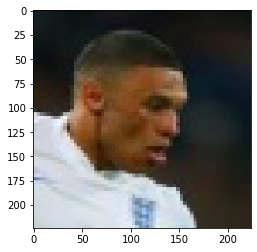

In [32]:
model_tester(full_model=model)

This model suggests the image below is a:  N000229  with a probability of 26.99 %
____________________________________
The ground truth is:   n000229
____________________________________

The two next most likely choices are: 
            N000110 with probability 18.62 % 
            N000285 with probability 16.69 %
____________________________________


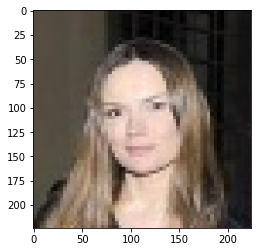

In [35]:
model_tester(full_model=model)

This model suggests the image below is a:  N000214  with a probability of 41.47 %
____________________________________
The ground truth is:   n000214
____________________________________

The two next most likely choices are: 
            N000204 with probability 30.28 % 
            N000038 with probability 4.89 %
____________________________________


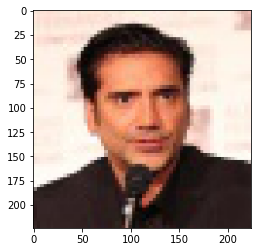

In [37]:
model_tester(full_model=model)

In [38]:
# save the model
model.save('/content/drive/MyDrive/ML Project/models/mobilenet.h5')